## 05- Usos del Modelo

Existen diversas aplicaciones de negocio con el resultado u output de la herramienta analítica de churn. Debido a que esta arroja una probabilidad (0 a 1) de que un cliente no renueve su póliza. Este valor puede asumirse como una medición del grado de satisfacción del cliente con el servicio u producto obtenido. En ese orden de ideas, diversas iniciativas pueden proponerse usando como fuente la probabilidad de churn de los clientes, algunas pueden ser:

- Caracterización de clientes de mayor riesgo de churn
- Estimación del customer value en términos de su probabilidad de churn
- Campañas de fidelización de los clientes con mayor riesgo de churn
- Estrategias de renovación o venta cruzada para los clientes de menor riesgo de churn

A continuación se realiza una pequeña caracterización de los clientes con mayor probabilidad de churn que tomaron pólizas en Febrero de 2022.

In [1]:
from model_parameters import *
import pickle
import pandas as pd
import numpy as np
from sklearn import set_config

set_config(display='diagram')

#cargue del modelo
with open("models/lightgbm.pickle", 'rb') as f:
    lightgbm = pickle.load(f)

with open("models/logistic.pickle", 'rb') as f:
    logistic = pickle.load(f)


### Cargue de data feb 2022 generada en notebook 01

In [2]:
data=pd.read_csv("polizas_feb22.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str},na_values="nan")

In [3]:
def pred_stack(data,proba=True,thresh=0.56):
    proba_lgb=lightgbm.predict_proba(data)[:,1]
    predict_log=logistic.predict_proba(data)[:,1]
    if proba:
        return np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)
    else:
        return (np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)>thresh).astype(int)

In [4]:
##calcular probabilidad de churn
proba_churn=pred_stack(data)
data['proba_churn']=proba_churn


### Regla de decisión
Al tener la probabilidad de churn, es necesario establecer el valor a partir del cual un cliente es considerado con alto riesgo de churn. Una alternativa es usar los quantiles de la distribución.

Percentil 25: 0.503 50: 0.544 y 75: 0.594 


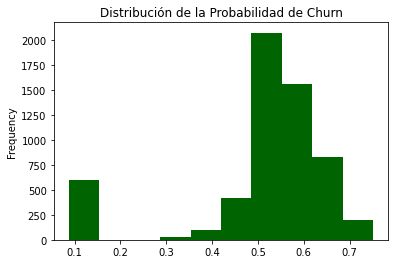

In [5]:
data.proba_churn.plot(kind="hist",title="Distribución de la Probabilidad de Churn", color="darkgreen");
print("Percentil 25: {:.3f} 50: {:.3f} y 75: {:.3f} ".format(*np.quantile(proba_churn,[0.25,0.5,0.75])))


Podría decirse que, basado en la distribución de probabilidades de churn de febrero de 2022, el 50% de las probabilidades más altas empiezan a partir de `0.544`. Por tanto asumimos este valor como el punto de corte para clasificar un cliente con alta probabilidad de churn.

In [6]:
clientes_riesgo=data.query("proba_churn>0.594")
print("Total Clientes con alto riesgo de churn: {}".format(clientes_riesgo.shape[0]))

Total Clientes con alto riesgo de churn: 1456


### Analicemos estos clientes

<AxesSubplot:ylabel='Frequency'>

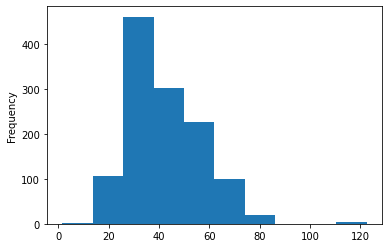

In [7]:
clientes_riesgo.edad.plot(kind="hist")

In [9]:
print("===Caracterización Clientes con Mayor Riesgo de Churn===")

for ramo in clientes_riesgo.tipo_ramo_name.value_counts().index.tolist():
    print(f"\n\t\t===== Ramo: {ramo} ===== \n\n\n \t *Características Cualitativas* ")

    for col in ['ciudad_name','tipo_prod_desc','EstadoCivil__pc','Genero__pc']:
        print(f"\n \tVariable: {col} \t\n")
        print(clientes_riesgo.query(f'tipo_ramo_name=="{ramo}"')[col].value_counts(sort=True).head(5))

    print("\n\t *Características Numéricas*")
    for col in ['total_siniestros','edad','AnnualRevenue']:
        value=clientes_riesgo.query(f"tipo_ramo_name=='{ramo}'")[col].median() if col !="AnnualRevenue" else clientes_riesgo[col].median()/(12*1000000)
        print(f"\n Variable: {col} Valor Mediano: {value:.2f} \t\n")
    value=clientes_riesgo.query(f"tipo_ramo_name=='{ramo}'")['proba_churn'].mean()
    print(f"\n Nivel de Riesgo de Fuga: {value:.2%} \t\n") 

===Caracterización Clientes con Mayor Riesgo de Churn===

		===== Ramo: automoviles ===== 


 	 *Características Cualitativas* 

 	Variable: ciudad_name 	

otras          814
BOGOTÁ D.C.     43
MEDELLIN        29
CÚCUTA          19
NEIVA           16
Name: ciudad_name, dtype: int64

 	Variable: tipo_prod_desc 	

automoviles    1135
Name: tipo_prod_desc, dtype: int64

 	Variable: EstadoCivil__pc 	

SOLTERO    583
CASADO     284
N A         79
OTRO        50
UNIDO       24
Name: EstadoCivil__pc, dtype: int64

 	Variable: Genero__pc 	

MASCULINO    703
FEMENINO     247
N A           75
Name: Genero__pc, dtype: int64

	 *Características Numéricas*

 Variable: total_siniestros Valor Mediano: 1.00 	


 Variable: edad Valor Mediano: 44.27 	


 Variable: AnnualRevenue Valor Mediano: 3.00 	


 Nivel de Riesgo de Fuga: 64.92% 	


		===== Ramo: responsabilidad civil ===== 


 	 *Características Cualitativas* 

 	Variable: ciudad_name 	

otras          273
MEDELLIN        15
BOGOTÁ D.C.     11
CAL

c:\Users\jhonp\miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Conclusiones


Una posible caracterización de los clientes con mayor riesgo de churn por tipo de ramo de producto es:

- Automoviles:

    - Principalmente `hombres solteros` de alrededor de `44 años` con ingresos de `3.25 SMMLV`, cuya `probabilidad de fuga promedio es del 61%`.

- Resp civil:

    - Principalmente `mujeres solteras` que toman el producto de `profesionales médicos`, tienen `32 años en promedio` e ingresos alrededor de `3.25 SMMLV`. Su `probabilidad de fuga es de 59%` en promedio

- Previhogar:

    - principalmente `hombres solteros` cuya edad ronda los `46 años`.


In [35]:
##exportar data de clientes

clientes_riesgo.to_csv("clientes_riesgofeb22.csv",sep=";",index=False)